In [1]:
import numpy as np
import xarray as xr

### Preliminaries

In [2]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
nex_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/nex-gddp/'
cil_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/cil-gdpcir/'
isi_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/isimip3b/regridded/conservative/'

out = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/uc_results/'

In [3]:
###################
# Models
###################
from utils import nex_ssp_dict, cil_ssp_dict, isimip_ssp_dict

nex_models = list(nex_ssp_dict.keys())
cil_models = list(cil_ssp_dict.keys())
isi_models = list(isimip_ssp_dict.keys())

In [4]:
######################################
# Prep each ensemble for merge
######################################
def preprocess_nex(ds):
    ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
    ds = ds.sortby('lon')
    ds = ds.sortby('ssp')
    ds = ds.assign_coords(ensemble = 'NEX')
    ds = ds.assign_coords(model = ds.encoding['source'][95:-3])
    ds['time'] = ds.indexes['time'].year
    return ds

def preprocess_cil(ds):
    ds = ds.sel(lat=slice(-60, 90))
    ds = ds.assign_coords(ensemble = 'CIL')
    ds = ds.sortby('ssp')
    ds = ds.assign_coords(model = ds.encoding['source'][97:-3])
    ds['time'] = ds.indexes['time'].year
    return ds

def preprocess_isi(ds):
    ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
    ds = ds.sortby('lon')
    ds = ds.sortby('ssp')
    ds = ds.assign_coords(ensemble = 'ISIMIP')
    ds = ds.assign_coords(model = ds.encoding['source'][118:-3])
    ds['time'] = ds.indexes['time'].year
    return ds

In [9]:
######################################
# Read all outputs for a given metric
######################################
def read_all(nex_in, cil_in, isi_in, metric):
    # read NEX
    ds_nex = xr.open_mfdataset(nex_in + '/' + metric + '/*', 
                               parallel=True, preprocess=preprocess_nex,
                               combine='nested', concat_dim='model',
                               chunks={'model':1, 'ssp':1, 'time':83, 'lat':600, 'lon':1440},
                               compat='identical').sel(lat=slice(40,50), lon=slice(0,10))
    
    # read CIL
    ds_cil = xr.open_mfdataset(cil_in + '/' + metric + '/*',
                               parallel=True, preprocess=preprocess_cil,
                               combine='nested', concat_dim='model',
                               chunks={'model':1, 'ssp':1, 'time':83, 'lat':600, 'lon':1440},
                               compat='identical').sel(lat=slice(40,50), lon=slice(0,10))
    
    # read ISIMIP
    ds_isi = xr.open_mfdataset(isi_in + '/' + metric + '/*',
                               parallel=True, preprocess=preprocess_isi,
                               combine='nested', concat_dim='model',
                               chunks={'model':1, 'ssp':1, 'time':83, 'lat':600, 'lon':1440},
                               compat='identical').sel(lat=slice(40,50), lon=slice(0,10))
    
    # merge all
    ds = xr.concat([ds_nex, ds_cil, ds_isi], dim='ensemble', fill_value=np.nan)
    
    # mask out ocean points (NEX is only available over land)
    ds_mask = ds.isel(ensemble=0, ssp=0, time=0, model=0)[list(ds.keys())[0]].isnull()
    ds = xr.where(ds_mask, np.nan, ds)
    
    return ds

In [6]:
###########################
####### HS09 method #######
###########################
def uc_hs09(ds):
    # Model uncertainty: variance across models, averaged over scenarios and ensembles
    U_model = ds.var(dim='model').mean(dim=['ssp', 'ensemble']).compute()

    # Scenario uncertainty STANDARD (HS09): variance across multi-model means
    U_scen = ds.mean(dim=['model', 'ensemble']).var(dim='ssp').compute()

    # # Scenario uncertainty LEE
    # Uscen_lee = ds.var(dim=['model', 'ensemble']).mean(dim='ssp').compute()

    # Downscaling uncertainy: variance across ensembles, averaged over models and scenarios
    U_ens = ds.var(dim='ensemble').mean(dim=['ssp', 'model']).compute()

    # Total uncertainty
    U_total = ds.var(dim=['ensemble', 'ssp', 'model']).compute()
    
    # Merge and return
    U_model = U_model.assign_coords(uncertainty = 'model')
    U_scen = U_scen.assign_coords(uncertainty = 'scenario')
    U_ens = U_ens.assign_coords(uncertainty = 'ensemble')
    U_total = U_total.assign_coords(uncertainty = 'total')
    
    return xr.concat([U_model, U_scen, U_ens, U_total], dim='uncertainty')

In [7]:
####################################
####### HS09 method with IAV #######
####################################
def uc_hs09_iav(ds_in, ds_rolling):
    # Total uncertainty including inter-annual variability
    U_total = ds_in.var(dim=['ensemble', 'ssp', 'model']).sel(time=slice(2020,2096)).compute()
        
    # Interannual variability (single value for all years)
    U_iav = (ds_in - ds_rolling).var(dim='time').mean(dim=['ensemble', 'ssp', 'model']).assign_coords(time = np.arange(2020,2097)).compute()
    
    ####### Work with forced response from here ########

    # Model uncertainty: variance across models, averaged over scenarios and ensembles
    U_model = ds_rolling.var(dim='model').mean(dim=['ssp', 'ensemble']).compute()

    # Scenario uncertainty: variance across multi-model means
    U_scen = ds_rolling.mean(dim=['model', 'ensemble']).var(dim='ssp').compute()

    # Downscaling uncertainy: variance across ensembles, averaged over models and scenarios
    U_ens = ds_rolling.var(dim='ensemble').mean(dim=['ssp', 'model']).compute()
    
    # Merge and return
    U_model = U_model.assign_coords(uncertainty = 'model')
    U_scen = U_scen.assign_coords(uncertainty = 'scenario')
    U_ens = U_ens.assign_coords(uncertainty = 'ensemble')
    U_iav = U_iav.assign_coords(uncertainty = 'variability')
    U_total = U_total.assign_coords(uncertainty = 'total')
    
    return xr.concat([U_model, U_scen, U_ens, U_iav, U_total], dim='uncertainty')

In [10]:
############
# Dask
############
from dask_jobqueue import PBSCluster

cluster = PBSCluster(cores=1, memory='20GB', resource_spec='pmem=20GB',
                     project='open',
                     env_extra=['#PBS -l feature=rhel7'], 
                     walltime='00:10:00')

cluster.scale(jobs=10)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.102.201.235:34083,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
cluster.scale(jobs=5)

In [11]:
# Read
ds = read_all(nex_in, cil_in, isi_in, 'annual_avgs')

# Persist for faster computation
ds = ds.persist()

# rechunk for SA calculations which involve acting along model, spp, ensemble dimensions
# ds = ds.chunk({'model':13, 'ssp':4, 'ensemble':2, 'time':43, 'lat':60, 'lon':144})
ds = ds.chunk({'model':13, 'ssp':4, 'ensemble':2, 'time':43, 'lat':10, 'lon':10})

In [ ]:
# Downscaling uncertainy: variance across ensembles, averaged over models and scenarios
U_ens = ds.var(dim='ensemble').compute()

In [49]:
# Weights
weights = ds.isel(time=0, lat=0, lon=0).tas.count(dim='ensemble').rename('weights')
weights = xr.where(weights == 1, 0, weights)

In [66]:
U_ens_weighted = U_ens.weighted(weights_upd).mean(dim=['ssp','model'])

In [68]:
U_ens_weighted

<xarray.Dataset>
Dimensions:  (lat: 40, lon: 40, time: 86)
Coordinates:
  * lat      (lat) float64 40.12 40.38 40.62 40.88 ... 49.12 49.38 49.62 49.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 9.125 9.375 9.625 9.875
  * time     (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
Data variables:
    tas      (lat, lon, time) float64 0.4415 0.4428 0.4497 ... 0.01977 0.02236
    tasmin   (lat, lon, time) float64 0.7 0.7147 0.6996 ... 0.1214 0.1251 0.1214
    tasmax   (lat, lon, time) float64 0.7631 0.7383 0.7765 ... 0.09918 0.1026
    pr       (lat, lon, time) float64 0.02172 0.02486 ... 0.07594 0.08045

In [54]:
U_ens_nonweighted = U_ens.mean(dim=['ssp','model'])

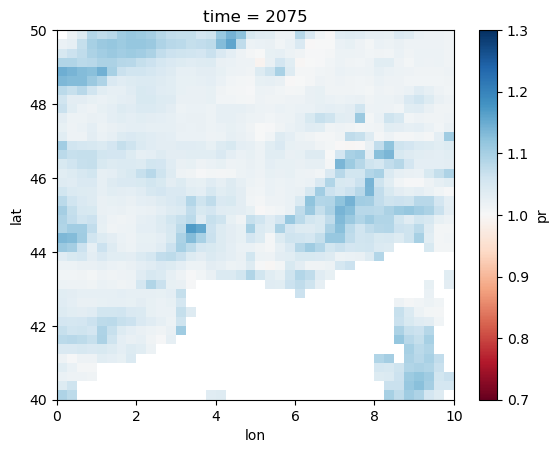

In [57]:
(U_ens_weighted.isel(time=60).pr / U_ens_nonweighted.isel(time=60).pr).plot(vmin=0.7, vmax=1.3, cmap='RdBu')

# Not including interannual variability

## Annual averages

In [10]:
# Read
ds = read_all(nex_in, cil_in, 'annual_avgs')

# Persist for faster computation
ds = ds.persist()

# rechunk for SA calculations which involve acting along model, spp, ensemble dimensions
ds = ds.chunk({'model':13, 'ssp':4, 'ensemble':2, 'time':43, 'lat':60, 'lon':144})

In [11]:
%%time
# HS09 method
ds_out = uc_hs09(ds)
ds_out.to_netcdf(out + 'cmip6/annual_avgs_HS09.nc')

# # K19
# ds_out = uc_k19(ds)
# ds_out.to_netcdf(out + 'cmip6/annual_avgs_K19.nc')

CPU times: user 3min 48s, sys: 18.4 s, total: 4min 6s
Wall time: 7min 39s


In [12]:
# clear
client.cancel(ds)

## Annual maxs

In [13]:
# Read
ds = read_all(nex_in, cil_in, 'annual_maxs')

# Persist for faster computation
ds = ds.persist()

# rechunk for SA calculations which involve acting along model, spp, ensemble dimensions
ds = ds.chunk({'model':13, 'ssp':4, 'ensemble':2, 'time':43, 'lat':60, 'lon':144})

In [14]:
%%time
# HS09 method
ds_out = uc_hs09(ds)
ds_out.to_netcdf(out + 'cmip6/annual_maxs_HS09.nc')

# # K19
# ds_out = uc_k19(ds)
# ds_out.to_netcdf(out + 'cmip6/annual_maxs_K19.nc')

CPU times: user 2min 54s, sys: 16.5 s, total: 3min 10s
Wall time: 6min 34s


In [15]:
# clear
client.cancel(ds)

## Annual mins

In [14]:
# Read
ds = read_all(nex_in, cil_in, 'annual_mins')

# Persist for faster computation
ds = ds.persist()

# rechunk for SA calculations which involve acting along model, spp, ensemble dimensions
ds = ds.chunk({'model':13, 'ssp':4, 'ensemble':2, 'time':43, 'lat':60, 'lon':144})

In [16]:
%%time
# HS09 method
ds_out = uc_hs09(ds)
ds_out.to_netcdf(out + 'cmip6/annual_mins_HS09.nc')

# # K19
# ds_out = uc_k19(ds)
# ds_out.to_netcdf(out + 'cmip6/annual_mins_K19.nc')

CPU times: user 1min 30s, sys: 7.32 s, total: 1min 37s
Wall time: 3min 14s


In [17]:
# clear
client.cancel(ds)

## Precip inds

In [40]:
# Read
ds = read_all(nex_in, cil_in, 'precip_inds')

# Persist for faster computation
ds = ds.persist()

# rechunk for SA calculations which involve acting along model, spp, ensemble dimensions
ds = ds.chunk({'model':13, 'ssp':4, 'ensemble':2, 'time':43, 'lat':60, 'lon':144})

In [41]:
%%time
# HS09 method
ds_out = uc_hs09(ds)
ds_out.to_netcdf(out + 'cmip6/precip_inds_HS09.nc')

# # K19
# ds_out = uc_k19(ds)
# ds_out.to_netcdf(out + 'cmip6/precip_inds_K19.nc')

CPU times: user 2min 43s, sys: 18.8 s, total: 3min 2s
Wall time: 7min 16s


In [42]:
# clear
client.cancel(ds)

# Including interannual variability

## Annual averages

In [11]:
# Read
ds = read_all(nex_in, cil_in, 'annual_avgs')

# Persist for faster computation
ds = ds.persist()
ds_rolling = ds.rolling(time=10, center=True).mean().sel(time=slice(2020,2096)).persist()

# rechunk for SA calculations which involve acting along model, spp, ensemble dimensions
ds = ds.chunk({'model':13, 'ssp':4, 'ensemble':2, 'time':43, 'lat':60, 'lon':144})
ds_rolling = ds_rolling.chunk({'model':13, 'ssp':4, 'ensemble':2, 'time':43, 'lat':60, 'lon':144})

In [12]:
%%time
# HS09 method
ds_out = uc_hs09_iav(ds, ds_rolling)
ds_out.to_netcdf(out + 'cmip6/annual_avgs_HS09_iav.nc')

CPU times: user 4min 41s, sys: 28.8 s, total: 5min 10s
Wall time: 10min 32s


In [ ]:
# clear
client.cancel(ds)
client.cancel(ds_rolling)

## Annual maxs

In [14]:
# Read
ds = read_all(nex_in, cil_in, 'annual_maxs')

# Persist for faster computation
ds = ds.persist()
ds_rolling = ds.rolling(time=10, center=True).mean().sel(time=slice(2020,2096)).persist()

# rechunk for SA calculations which involve acting along model, spp, ensemble dimensions
ds = ds.chunk({'model':13, 'ssp':4, 'ensemble':2, 'time':43, 'lat':60, 'lon':144})
ds_rolling = ds_rolling.chunk({'model':13, 'ssp':4, 'ensemble':2, 'time':43, 'lat':60, 'lon':144})

In [ ]:
%%time
# HS09 method
ds_out = uc_hs09_iav(ds, ds_rolling)
ds_out.to_netcdf(out + 'cmip6/annual_maxs_HS09_iav.nc')

In [ ]:
# clear
client.cancel(ds)
client.cancel(ds_rolling)

## Annual mins

In [ ]:
# Read
ds = read_all(nex_in, cil_in, 'annual_mins')

# Persist for faster computation
ds = ds.persist()

# rechunk for SA calculations which involve acting along model, spp, ensemble dimensions
ds = ds.chunk({'model':13, 'ssp':4, 'ensemble':2, 'time':43, 'lat':60, 'lon':144})

In [ ]:
%%time
# HS09 method
ds_out = uc_hs09_iav(ds)
ds_out.to_netcdf(out + 'cmip6/annual_mins_HS09_iav.nc')

In [ ]:
# clear
client.cancel(ds)

## Precip inds

In [18]:
# Read
ds = read_all(nex_in, cil_in, 'precip_inds')

# Persist for faster computation
ds = ds.persist()

# rechunk for SA calculations which involve acting along model, spp, ensemble dimensions
ds = ds.chunk({'model':13, 'ssp':4, 'ensemble':2, 'time':43, 'lat':60, 'lon':144})

In [ ]:
%%time
# HS09 method
ds_out = uc_hs09_iav(ds)
ds_out.to_netcdf(out + 'cmip6/precip_inds_HS09_iav.nc')

# # K19
# ds_out = uc_k19(ds)
# ds_out.to_netcdf(out + 'cmip6/precip_inds_K19.nc')

In [ ]:
# clear
client.cancel(ds)